<!-- HTML file automatically generated from DocOnce source (https://github.com/doconce/doconce/)
doconce format html week8.do.txt --no_mako --no_abort -->
<!-- dom:TITLE: Week 10 March 7-11: Resampling Techniques, Bootstrap and Blocking -->

# Week 10 March 7-11: Resampling Techniques, Bootstrap and Blocking
**Morten Hjorth-Jensen  Email morten.hjorth-jensen@fys.uio.no**, Department of Physics and Center fo Computing in Science Education, University of Oslo, Oslo, Norway and Department of Physics and Astronomy and Facility for Rare Ion Beams, Michigan State University, East Lansing, Michigan, USA

Date: **Mar 10, 2022**

Copyright 1999-2022, Morten Hjorth-Jensen  Email morten.hjorth-jensen@fys.uio.no. Released under CC Attribution-NonCommercial 4.0 license

## Overview of week 10, March 7-11
**Topics.**

* Top down approach first, what we need to code

* Resampling Techniques and statistics: Bootstrap and Blocking

**Teaching Material, videos and written material.**

* Overview video on the [Bootstrap method](https://www.youtube.com/watch?v=O_Fj4q8lgmc&ab_channel=MarinStatsLectures-RProgramming%26Statistics)

* These Lecture notes

* [Marius Johnson's Master thesis on the Blocking Method](https://www.duo.uio.no/bitstream/handle/10852/68360/PhysRevE.98.043304.pdf?sequence=2&isAllowed=y)

## The top-down approach, part 1

Last week we discussed how to implement a gradient descent method like the simplest possible gradient descent with a simple learning rate as parameter to tune. We repeat the codes here.

In [1]:
%matplotlib inline

# 2-electron VMC code for 2dim quantum dot with importance sampling
# Using gaussian rng for new positions and Metropolis- Hastings 
# Added energy minimization
# Common imports
from math import exp, sqrt
from random import random, seed, normalvariate
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import sys



# Trial wave function for the 2-electron quantum dot in two dims
def WaveFunction(r,alpha,beta):
    r1 = r[0,0]**2 + r[0,1]**2
    r2 = r[1,0]**2 + r[1,1]**2
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = r12/(1+beta*r12)
    return exp(-0.5*alpha*(r1+r2)+deno)

# Local energy  for the 2-electron quantum dot in two dims, using analytical local energy
def LocalEnergy(r,alpha,beta):
    
    r1 = (r[0,0]**2 + r[0,1]**2)
    r2 = (r[1,0]**2 + r[1,1]**2)
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = 1.0/(1+beta*r12)
    deno2 = deno*deno
    return 0.5*(1-alpha*alpha)*(r1 + r2) +2.0*alpha + 1.0/r12+deno2*(alpha*r12-deno2+2*beta*deno-1.0/r12)

# Derivate of wave function ansatz as function of variational parameters
def DerivativeWFansatz(r,alpha,beta):
    
    WfDer  = np.zeros((2), np.double)
    r1 = (r[0,0]**2 + r[0,1]**2)
    r2 = (r[1,0]**2 + r[1,1]**2)
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = 1.0/(1+beta*r12)
    deno2 = deno*deno
    WfDer[0] = -0.5*(r1+r2)
    WfDer[1] = -r12*r12*deno2
    return  WfDer

# Setting up the quantum force for the two-electron quantum dot, recall that it is a vector
def QuantumForce(r,alpha,beta):

    qforce = np.zeros((NumberParticles,Dimension), np.double)
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = 1.0/(1+beta*r12)
    qforce[0,:] = -2*r[0,:]*alpha*(r[0,:]-r[1,:])*deno*deno/r12
    qforce[1,:] = -2*r[1,:]*alpha*(r[1,:]-r[0,:])*deno*deno/r12
    return qforce
    

# Computing the derivative of the energy and the energy 
def EnergyMinimization(alpha, beta):

    NumberMCcycles= 10000
    # Parameters in the Fokker-Planck simulation of the quantum force
    D = 0.5
    TimeStep = 0.05
    # positions
    PositionOld = np.zeros((NumberParticles,Dimension), np.double)
    PositionNew = np.zeros((NumberParticles,Dimension), np.double)
    # Quantum force
    QuantumForceOld = np.zeros((NumberParticles,Dimension), np.double)
    QuantumForceNew = np.zeros((NumberParticles,Dimension), np.double)

    # seed for rng generator 
    seed()
    energy = 0.0
    DeltaE = 0.0
    EnergyDer = np.zeros((2), np.double)
    DeltaPsi = np.zeros((2), np.double)
    DerivativePsiE = np.zeros((2), np.double)
    #Initial position
    for i in range(NumberParticles):
        for j in range(Dimension):
            PositionOld[i,j] = normalvariate(0.0,1.0)*sqrt(TimeStep)
    wfold = WaveFunction(PositionOld,alpha,beta)
    QuantumForceOld = QuantumForce(PositionOld,alpha, beta)

    #Loop over MC MCcycles
    for MCcycle in range(NumberMCcycles):
        #Trial position moving one particle at the time
        for i in range(NumberParticles):
            for j in range(Dimension):
                PositionNew[i,j] = PositionOld[i,j]+normalvariate(0.0,1.0)*sqrt(TimeStep)+\
                                       QuantumForceOld[i,j]*TimeStep*D
            wfnew = WaveFunction(PositionNew,alpha,beta)
            QuantumForceNew = QuantumForce(PositionNew,alpha, beta)
            GreensFunction = 0.0
            for j in range(Dimension):
                GreensFunction += 0.5*(QuantumForceOld[i,j]+QuantumForceNew[i,j])*\
	                              (D*TimeStep*0.5*(QuantumForceOld[i,j]-QuantumForceNew[i,j])-\
                                      PositionNew[i,j]+PositionOld[i,j])
      
            GreensFunction = exp(GreensFunction)
            ProbabilityRatio = GreensFunction*wfnew**2/wfold**2
            #Metropolis-Hastings test to see whether we accept the move
            if random() <= ProbabilityRatio:
                for j in range(Dimension):
                    PositionOld[i,j] = PositionNew[i,j]
                    QuantumForceOld[i,j] = QuantumForceNew[i,j]
                wfold = wfnew
        DeltaE = LocalEnergy(PositionOld,alpha,beta)
        DerPsi = DerivativeWFansatz(PositionOld,alpha,beta)
        DeltaPsi += DerPsi
        energy += DeltaE
        DerivativePsiE += DerPsi*DeltaE
            
    # We calculate mean values
    energy /= NumberMCcycles
    DerivativePsiE /= NumberMCcycles
    DeltaPsi /= NumberMCcycles
    EnergyDer  = 2*(DerivativePsiE-DeltaPsi*energy)
    return energy, EnergyDer


#Here starts the main program with variable declarations
NumberParticles = 2
Dimension = 2
# guess for variational parameters
alpha = 0.95
beta = 0.3
# Set up iteration using stochastic gradient method
Energy = 0
EDerivative = np.zeros((2), np.double)
# Learning rate eta, max iterations, need to change to adaptive learning rate
eta = 0.01
MaxIterations = 50
iter = 0

Energies = np.zeros(MaxIterations)
EnergyDerivatives1 = np.zeros(MaxIterations)
EnergyDerivatives2 = np.zeros(MaxIterations)
AlphaValues = np.zeros(MaxIterations)
BetaValues = np.zeros(MaxIterations)

while iter < MaxIterations:
    Energy, EDerivative = EnergyMinimization(alpha,beta)
    alphagradient = EDerivative[0]
    betagradient = EDerivative[1]
    alpha -= eta*alphagradient
    beta -= eta*betagradient 
    Energies[iter] = Energy
    EnergyDerivatives1[iter] = EDerivative[0] 
    EnergyDerivatives2[iter] = EDerivative[1] 
    AlphaValues[iter] = alpha
    BetaValues[iter] = beta
    iter += 1

#nice printout with Pandas
import pandas as pd
from pandas import DataFrame
pd.set_option('max_columns', 6)
data ={'Alpha':AlphaValues,'Beta':BetaValues,'Energy':Energies,'Alpha Derivative':EnergyDerivatives1,'Beta Derivative':EnergyDerivatives2}

frame = pd.DataFrame(data)
print(frame)

       Alpha      Beta    Energy  Alpha Derivative  Beta Derivative
0   0.952296  0.301974  3.007138         -0.229565        -0.197434
1   0.954437  0.303799  3.014038         -0.214088        -0.182504
2   0.957111  0.305612  3.020428         -0.267489        -0.181273
3   0.959431  0.307527  3.008842         -0.231912        -0.191472
4   0.961444  0.309201  3.014196         -0.201396        -0.167395
5   0.963406  0.310757  3.021076         -0.196161        -0.155617
6   0.965298  0.312262  3.012516         -0.189152        -0.150510
7   0.967044  0.313691  3.013055         -0.174632        -0.142854
8   0.968671  0.315046  3.006198         -0.162681        -0.135577
9   0.970468  0.316366  3.012062         -0.179748        -0.131928
10  0.971836  0.317641  2.998432         -0.136801        -0.127550
11  0.973275  0.318896  3.007591         -0.143863        -0.125526
12  0.974744  0.320082  3.006142         -0.146915        -0.118539
13  0.975955  0.321323  2.993671         -0.1210

## What have we done?
The exact energy is $3.0$ for an oscillator frequency $\omega =1$
(with $\hbar =1$). We note however that with this learning rate and
number of iterations, the energies and the derivatives are not yet
converged.

We can improve upon this by using the algorithms provided by the **optimize** package in Python.
One of these algorithms is  Broyden–Fletcher–Goldfarb–Shanno (BFGS) algorithm. 

The optimization problem is to minimize $f(\mathbf {x} )$ where
$\mathbf {x}$ is a vector in $R^{n}$, and $f$ is a differentiable
scalar function. There are no constraints on the values that $\mathbf{x}$ can take.

The algorithm begins at an initial estimate for the optimal value
$\mathbf {x}_{0}$ and proceeds iteratively to get a better estimate at
each stage.

The search direction $p_k$ at stage $k$ is given by the solution of the analogue of the Newton equation

$$
B_{k}\mathbf {p} _{k}=-\nabla f(\mathbf {x}_{k}),
$$

where $B_{k}$ is an approximation to the Hessian matrix, which is
updated iteratively at each stage, and $\nabla f(\mathbf {x} _{k})$
is the gradient of the function
evaluated at $x_k$. 
A line search in the direction $p_k$ is then used to
find the next point $x_{k+1}$ by minimising

$$
f(\mathbf {x}_{k}+\alpha \mathbf {p}_{k}),
$$

over the scalar $\alpha > 0$.

## Code part 2
The modified code here uses the BFGS algorithm but performs now a
production run and writes to file all average values of the
energy.

In [2]:
# 2-electron VMC code for 2dim quantum dot with importance sampling
# Using gaussian rng for new positions and Metropolis- Hastings 
# Added energy minimization
from math import exp, sqrt
from random import random, seed, normalvariate
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.optimize import minimize
import sys
import os

# Where to save data files
PROJECT_ROOT_DIR = "Results"
DATA_ID = "Results/EnergyMin"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

outfile = open(data_path("Energies.dat"),'w')


# Trial wave function for the 2-electron quantum dot in two dims
def WaveFunction(r,alpha,beta):
    r1 = r[0,0]**2 + r[0,1]**2
    r2 = r[1,0]**2 + r[1,1]**2
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = r12/(1+beta*r12)
    return exp(-0.5*alpha*(r1+r2)+deno)

# Local energy  for the 2-electron quantum dot in two dims, using analytical local energy
def LocalEnergy(r,alpha,beta):
    
    r1 = (r[0,0]**2 + r[0,1]**2)
    r2 = (r[1,0]**2 + r[1,1]**2)
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = 1.0/(1+beta*r12)
    deno2 = deno*deno
    return 0.5*(1-alpha*alpha)*(r1 + r2) +2.0*alpha + 1.0/r12+deno2*(alpha*r12-deno2+2*beta*deno-1.0/r12)

# Derivate of wave function ansatz as function of variational parameters
def DerivativeWFansatz(r,alpha,beta):
    
    WfDer  = np.zeros((2), np.double)
    r1 = (r[0,0]**2 + r[0,1]**2)
    r2 = (r[1,0]**2 + r[1,1]**2)
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = 1.0/(1+beta*r12)
    deno2 = deno*deno
    WfDer[0] = -0.5*(r1+r2)
    WfDer[1] = -r12*r12*deno2
    return  WfDer

# Setting up the quantum force for the two-electron quantum dot, recall that it is a vector
def QuantumForce(r,alpha,beta):

    qforce = np.zeros((NumberParticles,Dimension), np.double)
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = 1.0/(1+beta*r12)
    qforce[0,:] = -2*r[0,:]*alpha*(r[0,:]-r[1,:])*deno*deno/r12
    qforce[1,:] = -2*r[1,:]*alpha*(r[1,:]-r[0,:])*deno*deno/r12
    return qforce
    

# Computing the derivative of the energy and the energy 
def EnergyDerivative(x0):

    
    # Parameters in the Fokker-Planck simulation of the quantum force
    D = 0.5
    TimeStep = 0.05
    # positions
    PositionOld = np.zeros((NumberParticles,Dimension), np.double)
    PositionNew = np.zeros((NumberParticles,Dimension), np.double)
    # Quantum force
    QuantumForceOld = np.zeros((NumberParticles,Dimension), np.double)
    QuantumForceNew = np.zeros((NumberParticles,Dimension), np.double)

    energy = 0.0
    DeltaE = 0.0
    alpha = x0[0]
    beta = x0[1]
    EnergyDer = 0.0
    DeltaPsi = 0.0
    DerivativePsiE = 0.0 
    #Initial position
    for i in range(NumberParticles):
        for j in range(Dimension):
            PositionOld[i,j] = normalvariate(0.0,1.0)*sqrt(TimeStep)
    wfold = WaveFunction(PositionOld,alpha,beta)
    QuantumForceOld = QuantumForce(PositionOld,alpha, beta)

    #Loop over MC MCcycles
    for MCcycle in range(NumberMCcycles):
        #Trial position moving one particle at the time
        for i in range(NumberParticles):
            for j in range(Dimension):
                PositionNew[i,j] = PositionOld[i,j]+normalvariate(0.0,1.0)*sqrt(TimeStep)+\
                                       QuantumForceOld[i,j]*TimeStep*D
            wfnew = WaveFunction(PositionNew,alpha,beta)
            QuantumForceNew = QuantumForce(PositionNew,alpha, beta)
            GreensFunction = 0.0
            for j in range(Dimension):
                GreensFunction += 0.5*(QuantumForceOld[i,j]+QuantumForceNew[i,j])*\
	                              (D*TimeStep*0.5*(QuantumForceOld[i,j]-QuantumForceNew[i,j])-\
                                      PositionNew[i,j]+PositionOld[i,j])
      
            GreensFunction = exp(GreensFunction)
            ProbabilityRatio = GreensFunction*wfnew**2/wfold**2
            #Metropolis-Hastings test to see whether we accept the move
            if random() <= ProbabilityRatio:
                for j in range(Dimension):
                    PositionOld[i,j] = PositionNew[i,j]
                    QuantumForceOld[i,j] = QuantumForceNew[i,j]
                wfold = wfnew
        DeltaE = LocalEnergy(PositionOld,alpha,beta)
        DerPsi = DerivativeWFansatz(PositionOld,alpha,beta)
        DeltaPsi += DerPsi
        energy += DeltaE
        DerivativePsiE += DerPsi*DeltaE
            
    # We calculate mean values
    energy /= NumberMCcycles
    DerivativePsiE /= NumberMCcycles
    DeltaPsi /= NumberMCcycles
    EnergyDer  = 2*(DerivativePsiE-DeltaPsi*energy)
    return EnergyDer


# Computing the expectation value of the local energy 
def Energy(x0):
    # Parameters in the Fokker-Planck simulation of the quantum force
    D = 0.5
    TimeStep = 0.05
    # positions
    PositionOld = np.zeros((NumberParticles,Dimension), np.double)
    PositionNew = np.zeros((NumberParticles,Dimension), np.double)
    # Quantum force
    QuantumForceOld = np.zeros((NumberParticles,Dimension), np.double)
    QuantumForceNew = np.zeros((NumberParticles,Dimension), np.double)

    energy = 0.0
    DeltaE = 0.0
    alpha = x0[0]
    beta = x0[1]
    #Initial position
    for i in range(NumberParticles):
        for j in range(Dimension):
            PositionOld[i,j] = normalvariate(0.0,1.0)*sqrt(TimeStep)
    wfold = WaveFunction(PositionOld,alpha,beta)
    QuantumForceOld = QuantumForce(PositionOld,alpha, beta)

    #Loop over MC MCcycles
    for MCcycle in range(NumberMCcycles):
        #Trial position moving one particle at the time
        for i in range(NumberParticles):
            for j in range(Dimension):
                PositionNew[i,j] = PositionOld[i,j]+normalvariate(0.0,1.0)*sqrt(TimeStep)+\
                                       QuantumForceOld[i,j]*TimeStep*D
            wfnew = WaveFunction(PositionNew,alpha,beta)
            QuantumForceNew = QuantumForce(PositionNew,alpha, beta)
            GreensFunction = 0.0
            for j in range(Dimension):
                GreensFunction += 0.5*(QuantumForceOld[i,j]+QuantumForceNew[i,j])*\
	                              (D*TimeStep*0.5*(QuantumForceOld[i,j]-QuantumForceNew[i,j])-\
                                      PositionNew[i,j]+PositionOld[i,j])
      
            GreensFunction = exp(GreensFunction)
            ProbabilityRatio = GreensFunction*wfnew**2/wfold**2
            #Metropolis-Hastings test to see whether we accept the move
            if random() <= ProbabilityRatio:
                for j in range(Dimension):
                    PositionOld[i,j] = PositionNew[i,j]
                    QuantumForceOld[i,j] = QuantumForceNew[i,j]
                wfold = wfnew
        DeltaE = LocalEnergy(PositionOld,alpha,beta)
        energy += DeltaE
        if Printout: 
           outfile.write('%f\n' %(DeltaE))#  ('%f\n' %(energy/(MCcycle+1.0)))                      
    # We calculate mean values
    energy /= NumberMCcycles
    return energy

#Here starts the main program with variable declarations
NumberParticles = 2
Dimension = 2
# seed for rng generator 
seed()
# Monte Carlo cycles for parameter optimization
Printout = False
NumberMCcycles= 10000
# guess for variational parameters
x0 = np.array([0.9,0.2])
# Using Broydens method to find optimal parameters
res = minimize(Energy, x0, method='BFGS', jac=EnergyDerivative, options={'gtol': 1e-4,'disp': True})
x0 = res.x
# Compute the energy again with the optimal parameters and increased number of Monte Cycles
NumberMCcycles= 2**19
Printout = True
FinalEnergy = Energy(x0)
EResult = np.array([FinalEnergy,FinalEnergy])
outfile.close()
#nice printout with Pandas
import pandas as pd
from pandas import DataFrame
data ={'Optimal Parameters':x0, 'Final Energy':EResult}
frame = pd.DataFrame(data)
print(frame)

         Current function value: 2.993133
         Iterations: 1
         Function evaluations: 21
         Gradient evaluations: 10
   Optimal Parameters  Final Energy
0            1.088016      3.010693
1            0.418129      3.010693


Note that the **minimize** function returns the final values for the
variable $\alpha=x0[0]$ and $\beta=x0[1]$ in the array $x$.

When we have found the minimum, we use these optimal parameters to perform a production run of energies.
The output is in turn written to file and is used, together with resampling methods like the **blocking method**,
to obtain the best possible estimate for the standard deviation.   The optimal minimum is, even with our guess, rather close to the exact value of $3.0$ a.u.

The [sampling
functions](https://github.com/CompPhysics/ComputationalPhysics2/tree/gh-pages/doc/Programs/Resampling)
can be used to perform both a blocking analysis, or a standard
bootstrap and jackknife analysis.

## How do we proceed?

There are several paths which can be chosen. One is to extend the
brute force gradient descent method with an adapative stochastic
gradient. There are several examples of this. A recent approach based
on [the Langevin equations](https://arxiv.org/pdf/1805.09416.pdf)
seems like a promising approach for general and possibly non-convex
optimization problems.

Here we would like to point out that our next step is now to use the
optimal values for our variational parameters and use these as inputs
to a production run. Here we would output values of the energy and
perform for example a blocking analysis of the results in order to get
a best possible estimate of the standard deviation.

## Resampling analysis

The next step is then to use the above data sets and perform a
resampling analysis, either using say the Bootstrap method or the
Blocking method. Since the data will be correlated, we would recommend
to use the non-iid Bootstrap code here. The theoretical background for these resampling methods is found in the [statistical analysis lecture notes](http://compphysics.github.io/ComputationalPhysics2/doc/pub/statanalysis/html/statanalysis.html)

Here we have tailored the codes to the output file from the previous example. We present first the bootstrap resampling with non-iid stochastic event.

In [3]:
# Common imports
import os

# Where to save the figures and data files
DATA_ID = "Results/EnergyMin"

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

infile = open(data_path("Energies.dat"),'r')

from numpy import std, mean, concatenate, arange, loadtxt, zeros, ceil
from numpy.random import randint
from time import time


def tsboot(data,statistic,R,l):
    t = zeros(R); n = len(data); k = int(ceil(float(n)/l));
    inds = arange(n); t0 = time()
    
    # time series bootstrap
    for i in range(R):
        # construct bootstrap sample from
        # k chunks of data. The chunksize is l
        _data = concatenate([data[j:j+l] for j in randint(0,n-l,k)])[0:n];
        t[i] = statistic(_data)

    # analysis
    print ("Runtime: %g sec" % (time()-t0)); print ("Bootstrap Statistics :")
    print ("original           bias      std. error")
    print ("%8g %14g %15g" % (statistic(data), \
                             mean(t) - statistic(data), \
                             std(t) ))
    return t
# Read in data
X = loadtxt(infile)
# statistic to be estimated. Takes two args.
# arg1: the data
def stat(data):
    return mean(data)
t = tsboot(X, stat, 2**12, 2**10)

Runtime: 2.60487 sec
Bootstrap Statistics :
original           bias      std. error
 3.01069   -8.80613e-06      0.00122621


The blocking code, based on the article of [Marius Jonsson](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.98.043304) is given here

In [4]:
# Common imports
import os

# Where to save the figures and data files
DATA_ID = "Results/EnergyMin"

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

infile = open(data_path("Energies.dat"),'r')

from numpy import log2, zeros, mean, var, sum, loadtxt, arange, array, cumsum, dot, transpose, diagonal, sqrt
from numpy.linalg import inv

def block(x):
    # preliminaries
    n = len(x)
    d = int(log2(n))
    s, gamma = zeros(d), zeros(d)
    mu = mean(x)

    # estimate the auto-covariance and variances 
    # for each blocking transformation
    for i in arange(0,d):
        n = len(x)
        # estimate autocovariance of x
        gamma[i] = (n)**(-1)*sum( (x[0:(n-1)]-mu)*(x[1:n]-mu) )
        # estimate variance of x
        s[i] = var(x)
        # perform blocking transformation
        x = 0.5*(x[0::2] + x[1::2])
   
    # generate the test observator M_k from the theorem
    M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]

    # we need a list of magic numbers
    q =array([6.634897,9.210340, 11.344867, 13.276704, 15.086272, 16.811894, 18.475307, 20.090235, 21.665994, 23.209251, 24.724970, 26.216967, 27.688250, 29.141238, 30.577914, 31.999927, 33.408664, 34.805306, 36.190869, 37.566235, 38.932173, 40.289360, 41.638398, 42.979820, 44.314105, 45.641683, 46.962942, 48.278236, 49.587884, 50.892181])

    # use magic to determine when we should have stopped blocking
    for k in arange(0,d):
        if(M[k] < q[k]):
            break
    if (k >= d-1):
        print("Warning: Use more data")
    return mu, s[k]/2**(d-k)


x = loadtxt(infile)
(mean, var) = block(x) 
std = sqrt(var)
import pandas as pd
from pandas import DataFrame
data ={'Mean':[mean], 'STDev':[std]}
frame = pd.DataFrame(data,index=['Values'])
print(frame)

            Mean     STDev
Values  3.010693  0.001199


## Why resampling methods ?
**Statistical analysis.**

    * Our simulations can be treated as *computer experiments*. This is particularly the case for Monte Carlo methods

    * The results can be analysed with the same statistical tools as we would use analysing experimental data.

    * As in all experiments, we are looking for expectation values and an estimate of how accurate they are, i.e., possible sources for errors.

## Statistical analysis
    * As in other experiments, many numerical  experiments have two classes of errors:

      * Statistical errors

      * Systematical errors

    * Statistical errors can be estimated using standard tools from statistics

    * Systematical errors are method specific and must be treated differently from case to case.

## Statistics
The *probability distribution function (PDF)* is a function
$p(x)$ on the domain which, in the discrete case, gives us the
probability or relative frequency with which these values of $X$ occur:

$$
p(x) = \mathrm{prob}(X=x)
$$

In the continuous case, the PDF does not directly depict the
actual probability. Instead we define the probability for the
stochastic variable to assume any value on an infinitesimal interval
around $x$ to be $p(x)dx$. The continuous function $p(x)$ then gives us
the *density* of the probability rather than the probability
itself. The probability for a stochastic variable to assume any value
on a non-infinitesimal interval $[a,\,b]$ is then just the integral:

$$
\mathrm{prob}(a\leq X\leq b) = \int_a^b p(x)dx
$$

Qualitatively speaking, a stochastic variable represents the values of
numbers chosen as if by chance from some specified PDF so that the
selection of a large set of these numbers reproduces this PDF.

## Statistics, moments
A particularly useful class of special expectation values are the
*moments*. The $n$-th moment of the PDF $p$ is defined as
follows:

$$
\langle x^n\rangle \equiv \int\! x^n p(x)\,dx
$$

The zero-th moment $\langle 1\rangle$ is just the normalization condition of
$p$. The first moment, $\langle x\rangle$, is called the *mean* of $p$
and often denoted by the letter $\mu$:

$$
\langle x\rangle = \mu \equiv \int\! x p(x)\,dx
$$

## Statistics, central moments
A special version of the moments is the set of *central moments*,
the n-th central moment defined as:

$$
\langle (x-\langle x \rangle )^n\rangle \equiv \int\! (x-\langle x\rangle)^n p(x)\,dx
$$

The zero-th and first central moments are both trivial, equal $1$ and
$0$, respectively. But the second central moment, known as the
*variance* of $p$, is of particular interest. For the stochastic
variable $X$, the variance is denoted as $\sigma^2_X$ or $\mathrm{var}(X)$:

<!-- Equation labels as ordinary links -->
<div id="_auto1"></div>

$$
\begin{equation}
\sigma^2_X\ \ =\ \ \mathrm{var}(X)  =  \langle (x-\langle x\rangle)^2\rangle =
\int\! (x-\langle x\rangle)^2 p(x)\,dx
\label{_auto1} \tag{1}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto2"></div>

$$
\begin{equation} 
 =  \int\! \left(x^2 - 2 x \langle x\rangle^{2} +
  \langle x\rangle^2\right)p(x)\,dx
\label{_auto2} \tag{2}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto3"></div>

$$
\begin{equation} 
 =  \langle x^2\rangle - 2 \langle x\rangle\langle x\rangle + \langle x\rangle^2
\label{_auto3} \tag{3}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto4"></div>

$$
\begin{equation} 
 =  \langle x^2\rangle - \langle x\rangle^2
\label{_auto4} \tag{4}
\end{equation}
$$

The square root of the variance, $\sigma =\sqrt{\langle (x-\langle x\rangle)^2\rangle}$ is called the *standard deviation* of $p$. It is clearly just the RMS (root-mean-square)
value of the deviation of the PDF from its mean value, interpreted
qualitatively as the *spread* of $p$ around its mean.

## Statistics, covariance
Another important quantity is the so called covariance, a variant of
the above defined variance. Consider again the set $\{X_i\}$ of $n$
stochastic variables (not necessarily uncorrelated) with the
multivariate PDF $P(x_1,\dots,x_n)$. The *covariance* of two
of the stochastic variables, $X_i$ and $X_j$, is defined as follows:

$$
\mathrm{cov}(X_i,\,X_j) \equiv \langle (x_i-\langle x_i\rangle)(x_j-\langle x_j\rangle)\rangle
\nonumber
$$

<!-- Equation labels as ordinary links -->
<div id="eq:def_covariance"></div>

$$
\begin{equation} 
=
\int\!\cdots\!\int\!(x_i-\langle x_i \rangle)(x_j-\langle x_j \rangle)\,
P(x_1,\dots,x_n)\,dx_1\dots dx_n
\label{eq:def_covariance} \tag{5}
\end{equation}
$$

with

$$
\langle x_i\rangle =
\int\!\cdots\!\int\!x_i\,P(x_1,\dots,x_n)\,dx_1\dots dx_n
$$

## Statistics, more covariance
If we consider the above covariance as a matrix $C_{ij}=\mathrm{cov}(X_i,\,X_j)$, then the diagonal elements are just the familiar
variances, $C_{ii} = \mathrm{cov}(X_i,\,X_i) = \mathrm{var}(X_i)$. It turns out that
all the off-diagonal elements are zero if the stochastic variables are
uncorrelated. This is easy to show, keeping in mind the linearity of
the expectation value. Consider the stochastic variables $X_i$ and
$X_j$, ($i\neq j$):

<!-- Equation labels as ordinary links -->
<div id="_auto5"></div>

$$
\begin{equation}
\mathrm{cov}(X_i,\,X_j) = \langle(x_i-\langle x_i\rangle)(x_j-\langle x_j\rangle)\rangle
\label{_auto5} \tag{6}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto6"></div>

$$
\begin{equation} 
=\langle x_i x_j - x_i\langle x_j\rangle - \langle x_i\rangle x_j + \langle x_i\rangle\langle x_j\rangle\rangle 
\label{_auto6} \tag{7}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto7"></div>

$$
\begin{equation} 
=\langle x_i x_j\rangle - \langle x_i\langle x_j\rangle\rangle - \langle \langle x_i\rangle x_j\rangle +
\langle \langle x_i\rangle\langle x_j\rangle\rangle
\label{_auto7} \tag{8}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto8"></div>

$$
\begin{equation} 
=\langle x_i x_j\rangle - \langle x_i\rangle\langle x_j\rangle - \langle x_i\rangle\langle x_j\rangle +
\langle x_i\rangle\langle x_j\rangle
\label{_auto8} \tag{9}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto9"></div>

$$
\begin{equation} 
=\langle x_i x_j\rangle - \langle x_i\rangle\langle x_j\rangle
\label{_auto9} \tag{10}
\end{equation}
$$

## Statistics, independent variables
If $X_i$ and $X_j$ are independent, we get 
$\langle x_i x_j\rangle =\langle x_i\rangle\langle x_j\rangle$, resulting in $\mathrm{cov}(X_i, X_j) = 0\ \ (i\neq j)$.

Also useful for us is the covariance of linear combinations of
stochastic variables. Let $\{X_i\}$ and $\{Y_i\}$ be two sets of
stochastic variables. Let also $\{a_i\}$ and $\{b_i\}$ be two sets of
scalars. Consider the linear combination:

$$
U = \sum_i a_i X_i \qquad V = \sum_j b_j Y_j
$$

By the linearity of the expectation value

$$
\mathrm{cov}(U, V) = \sum_{i,j}a_i b_j \mathrm{cov}(X_i, Y_j)
$$

## Statistics, more variance
Now, since the variance is just $\mathrm{var}(X_i) = \mathrm{cov}(X_i, X_i)$, we get
the variance of the linear combination $U = \sum_i a_i X_i$:

<!-- Equation labels as ordinary links -->
<div id="eq:variance_linear_combination"></div>

$$
\begin{equation}
\mathrm{var}(U) = \sum_{i,j}a_i a_j \mathrm{cov}(X_i, X_j)
\label{eq:variance_linear_combination} \tag{11}
\end{equation}
$$

And in the special case when the stochastic variables are
uncorrelated, the off-diagonal elements of the covariance are as we
know zero, resulting in:

$$
\mathrm{var}(U) = \sum_i a_i^2 \mathrm{cov}(X_i, X_i) = \sum_i a_i^2 \mathrm{var}(X_i)
$$

$$
\mathrm{var}(\sum_i a_i X_i) = \sum_i a_i^2 \mathrm{var}(X_i)
$$

which will become very useful in our study of the error in the mean
value of a set of measurements.

## Statistics and stochastic processes
A *stochastic process* is a process that produces sequentially a
chain of values:

$$
\{x_1, x_2,\dots\,x_k,\dots\}.
$$

We will call these
values our *measurements* and the entire set as our measured
*sample*.  The action of measuring all the elements of a sample
we will call a stochastic *experiment* since, operationally,
they are often associated with results of empirical observation of
some physical or mathematical phenomena; precisely an experiment. We
assume that these values are distributed according to some 
PDF $p_X^{\phantom X}(x)$, where $X$ is just the formal symbol for the
stochastic variable whose PDF is $p_X^{\phantom X}(x)$. Instead of
trying to determine the full distribution $p$ we are often only
interested in finding the few lowest moments, like the mean
$\mu_X^{\phantom X}$ and the variance $\sigma_X^{\phantom X}$.

## Statistics and sample variables
In practical situations a sample is always of finite size. Let that
size be $n$. The expectation value of a sample, the *sample mean*, is then defined as follows:

$$
\bar{x}_n \equiv \frac{1}{n}\sum_{k=1}^n x_k
$$

The *sample variance* is:

$$
\mathrm{var}(x) \equiv \frac{1}{n}\sum_{k=1}^n (x_k - \bar{x}_n)^2
$$

its square root being the *standard deviation of the sample*. The
*sample covariance* is:

$$
\mathrm{cov}(x)\equiv\frac{1}{n}\sum_{kl}(x_k - \bar{x}_n)(x_l - \bar{x}_n)
$$

## Statistics, sample variance and covariance
Note that the sample variance is the sample covariance without the
cross terms. In a similar manner as the covariance in Eq. ([5](#eq:def_covariance)) is a measure of the correlation between
two stochastic variables, the above defined sample covariance is a
measure of the sequential correlation between succeeding measurements
of a sample.

These quantities, being known experimental values, differ
significantly from and must not be confused with the similarly named
quantities for stochastic variables, mean $\mu_X$, variance $\mathrm{var}(X)$
and covariance $\mathrm{cov}(X,Y)$.

## Statistics, law of large numbers
The law of large numbers
states that as the size of our sample grows to infinity, the sample
mean approaches the true mean $\mu_X^{\phantom X}$ of the chosen PDF:

$$
\lim_{n\to\infty}\bar{x}_n = \mu_X^{\phantom X}
$$

The sample mean $\bar{x}_n$ works therefore as an estimate of the true
mean $\mu_X^{\phantom X}$.

What we need to find out is how good an approximation $\bar{x}_n$ is to
$\mu_X^{\phantom X}$. In any stochastic measurement, an estimated
mean is of no use to us without a measure of its error. A quantity
that tells us how well we can reproduce it in another experiment. We
are therefore interested in the PDF of the sample mean itself. Its
standard deviation will be a measure of the spread of sample means,
and we will simply call it the *error* of the sample mean, or
just sample error, and denote it by $\mathrm{err}_X^{\phantom X}$. In
practice, we will only be able to produce an *estimate* of the
sample error since the exact value would require the knowledge of the
true PDFs behind, which we usually do not have.

## Statistics, more on sample error
Let us first take a look at what happens to the sample error as the
size of the sample grows. In a sample, each of the measurements $x_i$
can be associated with its own stochastic variable $X_i$. The
stochastic variable $\overline X_n$ for the sample mean $\bar{x}_n$ is
then just a linear combination, already familiar to us:

$$
\overline X_n = \frac{1}{n}\sum_{i=1}^n X_i
$$

All the coefficients are just equal $1/n$. The PDF of $\overline X_n$,
denoted by $p_{\overline X_n}(x)$ is the desired PDF of the sample
means.

## Statistics
The probability density of obtaining a sample mean $\bar x_n$
is the product of probabilities of obtaining arbitrary values $x_1,
x_2,\dots,x_n$ with the constraint that the mean of the set $\{x_i\}$
is $\bar x_n$:

$$
p_{\overline X_n}(x) = \int p_X^{\phantom X}(x_1)\cdots
\int p_X^{\phantom X}(x_n)\ 
\delta\!\left(x - \frac{x_1+x_2+\dots+x_n}{n}\right)dx_n \cdots dx_1
$$

And in particular we are interested in its variance $\mathrm{var}(\overline X_n)$.

## The Central Limit Theorem

Suppose we have a PDF $p(x)$ from which we generate  a series $N$
of averages $\mathbb{E}[x_i]$. Each mean value $\mathbb{E}[x_i]$
is viewed as the average of a specific measurement, e.g., throwing 
dice 100 times and then taking the average value, or producing a certain
amount of random numbers. 
For notational ease, we set $\mathbb{E}[x_i]=x_i$ in the discussion
which follows. We do the same for $\mathbb{E}[z]=z$.

If we compute the mean $z$ of $m$ such mean values $x_i$

$$
z=\frac{x_1+x_2+\dots+x_m}{m},
$$

the question we pose is which is the PDF of the new variable $z$.

## Finding the Limit

The probability of obtaining an average value $z$ is the product of the 
probabilities of obtaining arbitrary individual mean values $x_i$,
but with the constraint that the average is $z$. We can express this through
the following expression

$$
\tilde{p}(z)=\int dx_1p(x_1)\int dx_2p(x_2)\dots\int dx_mp(x_m)
    \delta(z-\frac{x_1+x_2+\dots+x_m}{m}),
$$

where the $\delta$-function enbodies the constraint that the mean is $z$.
All measurements that lead to each individual $x_i$ are expected to
be independent, which in turn means that we can express $\tilde{p}$ as the 
product of individual $p(x_i)$.  The independence assumption is important in the derivation of the central limit theorem.

## Rewriting the $\delta$-function

If we use the integral expression for the $\delta$-function

$$
\delta(z-\frac{x_1+x_2+\dots+x_m}{m})=\frac{1}{2\pi}\int_{-\infty}^{\infty}
   dq\exp{\left(iq(z-\frac{x_1+x_2+\dots+x_m}{m})\right)},
$$

and inserting $e^{i\mu q-i\mu q}$ where $\mu$ is the mean value
we arrive at

$$
\tilde{p}(z)=\frac{1}{2\pi}\int_{-\infty}^{\infty}
   dq\exp{\left(iq(z-\mu)\right)}\left[\int_{-\infty}^{\infty}
   dxp(x)\exp{\left(iq(\mu-x)/m\right)}\right]^m,
$$

with the integral over $x$ resulting in

$$
\int_{-\infty}^{\infty}dxp(x)\exp{\left(iq(\mu-x)/m\right)}=
  \int_{-\infty}^{\infty}dxp(x)
   \left[1+\frac{iq(\mu-x)}{m}-\frac{q^2(\mu-x)^2}{2m^2}+\dots\right].
$$

## Identifying Terms

The second term on the rhs disappears since this is just the mean and 
employing the definition of $\sigma^2$ we have

$$
\int_{-\infty}^{\infty}dxp(x)e^{\left(iq(\mu-x)/m\right)}=
  1-\frac{q^2\sigma^2}{2m^2}+\dots,
$$

resulting in

$$
\left[\int_{-\infty}^{\infty}dxp(x)\exp{\left(iq(\mu-x)/m\right)}\right]^m\approx
  \left[1-\frac{q^2\sigma^2}{2m^2}+\dots \right]^m,
$$

and in the limit $m\rightarrow \infty$ we obtain

$$
\tilde{p}(z)=\frac{1}{\sqrt{2\pi}(\sigma/\sqrt{m})}
    \exp{\left(-\frac{(z-\mu)^2}{2(\sigma/\sqrt{m})^2}\right)},
$$

which is the normal distribution with variance
$\sigma^2_m=\sigma^2/m$, where $\sigma$ is the variance of the PDF $p(x)$
and $\mu$ is also the mean of the PDF $p(x)$.

## Wrapping it up

Thus, the central limit theorem states that the PDF $\tilde{p}(z)$ of
the average of $m$ random values corresponding to a PDF $p(x)$ 
is a normal distribution whose mean is the 
mean value of the PDF $p(x)$ and whose variance is the variance
of the PDF $p(x)$ divided by $m$, the number of values used to compute $z$.

The central limit theorem leads to the well-known expression for the
standard deviation, given by

$$
\sigma_m=
\frac{\sigma}{\sqrt{m}}.
$$

The latter is true only if the average value is known exactly. This is obtained in the limit
$m\rightarrow \infty$  only. Because the mean and the variance are measured quantities we obtain 
the familiar expression in statistics (the so-called Bessel correction)

$$
\sigma_m\approx 
\frac{\sigma}{\sqrt{m-1}}.
$$

In many cases however the above estimate for the standard deviation,
in particular if correlations are strong, may be too simplistic. Keep
in mind that we have assumed that the variables $x$ are independent
and identically distributed. This is obviously not always the
case. For example, the random numbers (or better pseudorandom numbers)
we generate in various calculations do always exhibit some
correlations.

The theorem is satisfied by a large class of PDFs. Note however that for a
finite $m$, it is not always possible to find a closed form /analytic expression for
$\tilde{p}(x)$.

## Resampling methods: Bootstrap steps

The independent bootstrap works like this: 

1. Draw with replacement $n$ numbers for the observed variables $\boldsymbol{x} = (x_1,x_2,\cdots,x_n)$. 

2. Define a vector $\boldsymbol{x}^*$ containing the values which were drawn from $\boldsymbol{x}$. 

3. Using the vector $\boldsymbol{x}^*$ compute $\widehat{\beta}^*$ by evaluating $\widehat \beta$ under the observations $\boldsymbol{x}^*$. 

4. Repeat this process $k$ times. 

When you are done, you can draw a histogram of the relative frequency
of $\widehat \beta^*$. This is your estimate of the probability
distribution $p(t)$. Using this probability distribution you can
estimate any statistics thereof. In principle you never draw the
histogram of the relative frequency of $\widehat{\beta}^*$. Instead
you use the estimators corresponding to the statistic of interest. For
example, if you are interested in estimating the variance of $\widehat
\beta$, apply the etsimator $\widehat \sigma^2$ to the values
$\widehat \beta^*$.

## Code example for the Bootstrap method and demonstration of central limit theorem

The following code starts with a Gaussian distribution with mean value
$\mu =100$ and variance $\sigma=15$. We use this to generate the data
used in the bootstrap analysis. The bootstrap analysis returns a data
set after a given number of bootstrap operations (as many as we have
data points). This data set consists of estimated mean values for each
bootstrap operation. The histogram generated by the bootstrap method
shows that the distribution for these mean values is also a Gaussian,
centered around the mean value $\mu=100$ but with standard deviation
$\sigma/\sqrt{n}$, where $n$ is the number of bootstrap samples (in
this case the same as the number of original data points). The value
of the standard deviation is what we expect from the central limit
theorem.

In [7]:
import numpy as np
from time import time
from scipy.stats import norm
import matplotlib.pyplot as plt

# Returns mean of bootstrap samples 
# Bootstrap algorithm
def bootstrap(data, datapoints):
    t = np.zeros(datapoints)
    n = len(data)
    # non-parametric bootstrap         
    for i in range(datapoints):
        t[i] = np.mean(data[np.random.randint(0,n,n)])
    # analysis    
    print("Bootstrap Statistics :")
    print("original           bias      std. error")
    print("%8g %8g %14g %15g" % (np.mean(data), np.std(data),np.mean(t),np.std(t)))
    return t

# We set the mean value to 100 and the standard deviation to 15
mu, sigma = 100, 15
datapoints = 100000
# We generate random numbers according to the normal distribution
x = mu + sigma*np.random.randn(datapoints)
# bootstrap returns the data sample                                    
t = bootstrap(x, datapoints)

Bootstrap Statistics :
original           bias      std. error
 100.016   14.983        100.016       0.0473264


We see that our new variance and from that the standard deviation, agrees with the central limit theorem.

## Plotting the Histogram

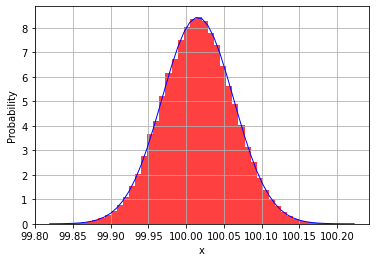

In [8]:
# the histogram of the bootstrapped data (normalized data if density = True)
n, binsboot, patches = plt.hist(t, 50, density=True, facecolor='red', alpha=0.75)
# add a 'best fit' line  
y = norm.pdf(binsboot, np.mean(t), np.std(t))
lt = plt.plot(binsboot, y, 'b', linewidth=1)
plt.xlabel('x')
plt.ylabel('Probability')
plt.grid(True)
plt.show()

## Statistics, more technicalities
The desired variance
$\mathrm{var}(\overline X_n)$, i.e. the sample error squared
$\mathrm{err}_X^2$, is given by:

<!-- Equation labels as ordinary links -->
<div id="eq:error_exact"></div>

$$
\begin{equation}
\mathrm{err}_X^2 = \mathrm{var}(\overline X_n) = \frac{1}{n^2}
\sum_{ij} \mathrm{cov}(X_i, X_j)
\label{eq:error_exact} \tag{12}
\end{equation}
$$

We see now that in order to calculate the exact error of the sample
with the above expression, we would need the true means
$\mu_{X_i}^{\phantom X}$ of the stochastic variables $X_i$. To
calculate these requires that we know the true multivariate PDF of all
the $X_i$. But this PDF is unknown to us, we have only got the measurements of
one sample. The best we can do is to let the sample itself be an
estimate of the PDF of each of the $X_i$, estimating all properties of
$X_i$ through the measurements of the sample.

## Statistics
Our estimate of $\mu_{X_i}^{\phantom X}$ is then the sample mean $\bar x$
itself, in accordance with the the central limit theorem:

$$
\mu_{X_i}^{\phantom X} = \langle x_i\rangle \approx \frac{1}{n}\sum_{k=1}^n x_k = \bar x
$$

Using $\bar x$ in place of $\mu_{X_i}^{\phantom X}$ we can give an
*estimate* of the covariance in Eq. ([12](#eq:error_exact))

$$
\mathrm{cov}(X_i, X_j) = \langle (x_i-\langle x_i\rangle)(x_j-\langle x_j\rangle)\rangle
\approx\langle (x_i - \bar x)(x_j - \bar{x})\rangle,
$$

resulting in

$$
\frac{1}{n} \sum_{l}^n \left(\frac{1}{n}\sum_{k}^n (x_k -\bar x_n)(x_l - \bar x_n)\right)=\frac{1}{n}\frac{1}{n} \sum_{kl} (x_k -\bar x_n)(x_l - \bar x_n)=\frac{1}{n}\mathrm{cov}(x)
$$

## Statistics and sample variance
By the same procedure we can use the sample variance as an
estimate of the variance of any of the stochastic variables $X_i$

$$
\mathrm{var}(X_i)=\langle x_i - \langle x_i\rangle\rangle \approx \langle x_i - \bar x_n\rangle\nonumber,
$$

which is approximated as

<!-- Equation labels as ordinary links -->
<div id="eq:var_estimate_i_think"></div>

$$
\begin{equation}
\mathrm{var}(X_i)\approx \frac{1}{n}\sum_{k=1}^n (x_k - \bar x_n)=\mathrm{var}(x)
\label{eq:var_estimate_i_think} \tag{13}
\end{equation}
$$

Now we can calculate an estimate of the error
$\mathrm{err}_X^{\phantom X}$ of the sample mean $\bar x_n$:

$$
\mathrm{err}_X^2
=\frac{1}{n^2}\sum_{ij} \mathrm{cov}(X_i, X_j) \nonumber
$$

$$
\approx\frac{1}{n^2}\sum_{ij}\frac{1}{n}\mathrm{cov}(x) =\frac{1}{n^2}n^2\frac{1}{n}\mathrm{cov}(x)\nonumber
$$

<!-- Equation labels as ordinary links -->
<div id="eq:error_estimate"></div>

$$
\begin{equation} 
=\frac{1}{n}\mathrm{cov}(x)
\label{eq:error_estimate} \tag{14}
\end{equation}
$$

which is nothing but the sample covariance divided by the number of
measurements in the sample.

## Statistics, uncorrelated results

In the special case that the measurements of the sample are
uncorrelated (equivalently the stochastic variables $X_i$ are
uncorrelated) we have that the off-diagonal elements of the covariance
are zero. This gives the following estimate of the sample error:

$$
\mathrm{err}_X^2=\frac{1}{n^2}\sum_{ij} \mathrm{cov}(X_i, X_j) =
\frac{1}{n^2} \sum_i \mathrm{var}(X_i),
$$

resulting in

<!-- Equation labels as ordinary links -->
<div id="eq:error_estimate_uncorrel"></div>

$$
\begin{equation}
\mathrm{err}_X^2\approx \frac{1}{n^2} \sum_i \mathrm{var}(x)= \frac{1}{n}\mathrm{var}(x)
\label{eq:error_estimate_uncorrel} \tag{15}
\end{equation}
$$

where in the second step we have used Eq. ([13](#eq:var_estimate_i_think)).
The error of the sample is then just its standard deviation divided by
the square root of the number of measurements the sample contains.
This is a very useful formula which is easy to compute. It acts as a
first approximation to the error, but in numerical experiments, we
cannot overlook the always present correlations.

## Statistics, computations
For computational purposes one usually splits up the estimate of
$\mathrm{err}_X^2$, given by Eq. ([14](#eq:error_estimate)), into two
parts

$$
\mathrm{err}_X^2 = \frac{1}{n}\mathrm{var}(x) + \frac{1}{n}(\mathrm{cov}(x)-\mathrm{var}(x)),
$$

which equals

<!-- Equation labels as ordinary links -->
<div id="eq:error_estimate_split_up"></div>

$$
\begin{equation}
\frac{1}{n^2}\sum_{k=1}^n (x_k - \bar x_n)^2 +\frac{2}{n^2}\sum_{k<l} (x_k - \bar x_n)(x_l - \bar x_n)
\label{eq:error_estimate_split_up} \tag{16}
\end{equation}
$$

The first term is the same as the error in the uncorrelated case,
Eq. ([15](#eq:error_estimate_uncorrel)). This means that the second
term accounts for the error correction due to correlation between the
measurements. For uncorrelated measurements this second term is zero.

## Statistics, more on computations of errors
Computationally the uncorrelated first term is much easier to treat
efficiently than the second.

$$
\mathrm{var}(x) = \frac{1}{n}\sum_{k=1}^n (x_k - \bar x_n)^2 =
\left(\frac{1}{n}\sum_{k=1}^n x_k^2\right) - \bar x_n^2
$$

We just accumulate separately the values $x^2$ and $x$ for every
measurement $x$ we receive. The correlation term, though, has to be
calculated at the end of the experiment since we need all the
measurements to calculate the cross terms. Therefore, all measurements
have to be stored throughout the experiment.